# Post training quantization of SpeechBrain Wav2Vec2 on GPU


This notebook provides code for post training quantization of the speechbrain/asr-wav2vec2-commonvoice-en model. We compare base model and post training quantizated model on the timit_asr dataset.

First, let's install `datasets`,  `transformers` and `librosa`.

In [ ]:
# %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [2]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [3]:
! git clone https://github.com/NVIDIA/TensorRT.git

fatal: destination path 'TensorRT' already exists and is not an empty directory.


In [ ]:
! cd TensorRT/tools/pytorch-quantization && pip install .

In [5]:
! pip install --upgrade tensorrt

Defaulting to user installation because normal site-packages is not writeable


## Prepare Data, Tokenizer, Feature Extractor

In [6]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

Reusing dataset timit_asr (/home/kmb85/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

We normalize the text to only have lower case letters and append a word separator token at the end.

In [8]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [ ]:
timit = timit.map(remove_special_characters)

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.

In [10]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [11]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [12]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [13]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

We also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm.

In [14]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [15]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

Let's now save the vocabulary as a json file.

In [16]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [17]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

### Create Wav2Vec2 Feature Extractor

In [18]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [19]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Let's apply the data preparation function to all examples.

In [20]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

In [22]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

## Base Model

In [23]:
from speechbrain.pretrained import EncoderDecoderASR

torchvision is not available - cannot save figures


In [ ]:
asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

In [ ]:
torch.onnx.export(asr_model.mods.encoder.wav2vec2.model,
             args=torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
) 

## Post Training Quantization

In [25]:
import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [26]:
model_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

Some weights of the model checkpoint at facebook/wav2vec2-large-lv60 were not used when initializing Wav2Vec2Model: ['quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_hid.bias', 'project_hid.weight', 'project_q.weight', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
W1223 18:20:12.079474 139948017184768 huggingface_wav2vec.py:146] speechbrain.lobes.models.huggingface_wav2vec - wav2vec 2.0 is frozen.


In [27]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=8, fake_quant=True)
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)

In [28]:
quant_modules.initialize()
model_full_quantized = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", savedir="pretrained_models/asr-wav2vec2-commonvoice-en", run_opts={"device":"cuda"})

Some weights of the model checkpoint at facebook/wav2vec2-large-lv60 were not used when initializing Wav2Vec2Model: ['quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_hid.bias', 'project_hid.weight', 'project_q.weight', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
W1223 18:20:18.201615 139948017184768 huggingface_wav2vec.py:146] speechbrain.lobes.models.huggingface_wav2vec - wav2vec 2.0 is frozen.


First, calibrate the quantized model

In [29]:
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_calib()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_quant()

In [30]:
import torch
with torch.no_grad():
    for i in range(2000):
            _ = model_full_quantized.mods.encoder.wav2vec2.model(torch.tensor(timit["train"][i:i+1]["input_values"], device="cuda"))

In [31]:
# Finalize calibration
        
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.load_calib_amax()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.disable_calib()
model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv._weight_quantizer.enable_quant()

model_full_quantized.cuda()

W1223 18:22:31.394114 139948017184768 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([512, 1, 1]).
W1223 18:22:31.394858 139948017184768 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1223 18:22:31.395445 139948017184768 tensor_quantizer.py:174] Disable MaxCalibrator


EncoderDecoderASR(
  (mods): ModuleDict(
    (encoder): LengthsCapableSequential(
      (wav2vec2): HuggingFaceWav2Vec2(
        (model): Wav2Vec2Model(
          (feature_extractor): Wav2Vec2FeatureEncoder(
            (conv_layers): ModuleList(
              (0): Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  1, 512, kernel_size=(10,), stride=(5,)
                  (_input_quantizer): TensorQuantizer(8bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
                  (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=[0.0088, 0.6672](512) calibrator=MaxCalibrator scale=1.0 quant)
                )
                (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (activation): GELUActivation()
              )
              (1-4): 4 x Wav2Vec2LayerNormConvLayer(
                (conv): QuantConv1d(
                  512, 512, kernel_size=(3,), stride=(2,)
                  (_input_qu

In our final quantized model, we only keep the quantized first conv layer.

In [32]:
model_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv = model_full_quantized.mods.encoder.wav2vec2.model.feature_extractor.conv_layers[0].conv

The `pytorch-quantization` only provides `fake` quantization. The quantization is simulatedon the model's weights and activations without actually converting them to lower-bit representations. To get the quantized model, we need to export the model to ONNX. Fake quantization will be broken into a pair of QuantizeLinear/DequantizeLinear ONNX operations. TensorRT will take the generated ONNX graph, and execute it in int8 in the most optimized way to its capability.

In [ ]:
torch.onnx.export(model_quantized.mods.encoder.wav2vec2.model,
             args=torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             f="asr-wav2vec2-encoder-quantized.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

### Base vs Quantized Model Inference Time

In this section, we compare the inference time of the base model and the quantized model on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [35]:
! pip install onnxruntime-gpu

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 MB 11.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 12.0 MB/s eta 0:00:00


In [35]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [ ]:
# Load onnx models
ort_sess_quant = ort.InferenceSession('asr-wav2vec2-encoder-quantized.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_base = ort.InferenceSession('asr-wav2vec2-encoder.onnx')

In [37]:
import time
import numpy 

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in timit["test"].select(range(num_samples)):
            input_values = torch.tensor(single_batch["input_values"], device="cpu").unsqueeze(0)
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 2)

In [38]:
num_samples = 50

base_model_time = compute_inference_time(ort_sess_base, num_samples)

In [39]:
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.15 seconds


In [58]:
quantized_model_time = compute_inference_time(ort_sess_quant, num_samples)

In [59]:
print(f'Quantized Model inference time {quantized_model_time} seconds')

Quantized Model inference time 0.01 seconds


**Inference Time Visualisation of Results**

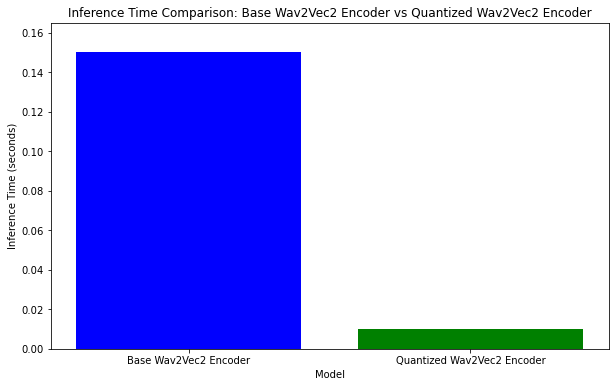

In [60]:
import matplotlib.pyplot as plt

models = ['Base Wav2Vec2 Encoder', 'Quantized Wav2Vec2 Encoder']
inference_times = [base_model_time, quantized_model_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base Wav2Vec2 Encoder vs Quantized Wav2Vec2 Encoder')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

We calculate how many times the quantized model is faster than the base model

In [61]:
speedup_ratio = base_model_time / quantized_model_time
print(f'Quantized wav2vec2 encoder is {round(speedup_ratio)} times faster than base wav2vec2 encoder')

Quantized wav2vec2 encoder is 15 times faster than base wav2vec2 encoder


**Evaluating WER metric**

In [44]:
wer_metric = load_metric("wer")

In [45]:
def map_model_to_wer_result(model, single_batch):
    input_values = torch.tensor(single_batch["input_values"]).to('cuda')
    with torch.no_grad():
        prediction = model(input_values, torch.tensor([1.0]).to('cuda'))
    
    pred_str = [' '.join(prediction[0]).lower()]
    correct_str = processor.batch_decode(single_batch['labels'], group_tokens=False)
    return wer_metric.compute(predictions=pred_str, references=correct_str)

In [46]:
num_samples = 500

In [ ]:
total_wer = 0

for i in range(num_samples):
    total_wer += map_model_to_wer_result(asr_model, timit['test'][i:i+1])
    
base_wer_result = round(total_wer / num_samples, 8)

In [48]:
print(f'Base Model WER: {base_wer_result}')

Base Model WER: 0.10934624


In [49]:
asr_model.mods.encoder.wav2vec2.model = model_quantized.mods.encoder.wav2vec2.model

In [50]:
total_wer_quant = 0

for i in range(num_samples):
    total_wer_quant += map_model_to_wer_result(asr_model, timit['test'][i:i+1])
    
quant_wer_result = round(total_wer_quant / num_samples, 4)

In [51]:
print(f'Quantized Model WER: {quant_wer_result}')

Quantized Model WER: 0.1162


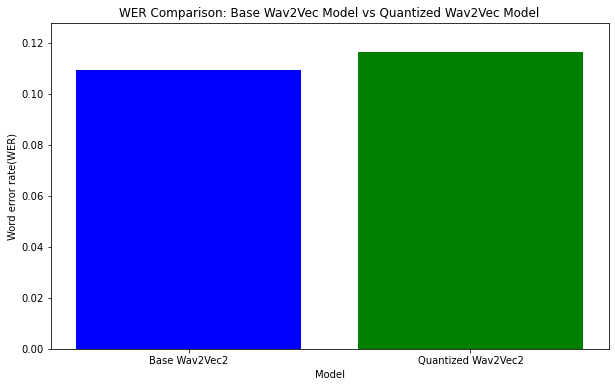

In [52]:
import matplotlib.pyplot as plt

models = ['Base Wav2Vec2', 'Quantized Wav2Vec2']
inference_times = [base_wer_result, quant_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base Wav2Vec Model vs Quantized Wav2Vec Model')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

In [53]:
percentage_diff = ((quant_wer_result - base_wer_result) / quant_wer_result) * 100
print(f'WER difference between the quantized model and the base model is {round(percentage_diff, 2)}%')

WER difference between the quantized model and the base model is 5.9%
